### To keep colab running

In [ ]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
'''

# Drive setup

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('drive/MyDrive/CRISPR_DeepHF')

In [ ]:
!pwd
!ls

/content
drive  sample_data


# Taking necessary columns and Test set separation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

In [ ]:
file_name = "deephf_data.xlsx"
df = pd.read_excel(file_name, sheet_name="Sheet1")
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df['Wt_Efficiency'] = pd.to_numeric(df['Wt_Efficiency'])
df['eSpCas 9_Efficiency'] = pd.to_numeric(df['eSpCas 9_Efficiency'])
df['SpCas9-HF1_Efficiency'] = pd.to_numeric(df['SpCas9-HF1_Efficiency'])
print(df.shape)
df.head(3)

(59852, 8)


,NaN,gRNA,gRNA_Seq,PAM,21mer,Wt_Efficiency,eSpCas 9_Efficiency,SpCas9-HF1_Efficiency
1,NaN,gRNA-1,AAAAAAAAACTCCAAAACCC,TGG,AAAAAAAAACTCCAAAACCCT,0.168570,0.142063,0.093147
2,NaN,gRNA-2,AAAAAACAACAAGAAGCACA,AGG,AAAAAACAACAAGAAGCACAA,0.099624,0.051901,0.064951
3,NaN,gRNA-3,AAAAAACACAAGCAAGACCG,TGG,AAAAAACACAAGCAAGACCGT,0.247750,0.043573,0.061797


In [ ]:
cas_name = 'Wt_Efficiency'

# df1 = df[['21mer','Wt_Efficiency','eSpCas 9_Efficiency','SpCas9-HF1_Efficiency']]
df1 = df[['21mer', cas_name]]

print(df1.shape)
df1.head(3)

(59852, 2)


,21mer,Wt_Efficiency
1,AAAAAAAAACTCCAAAACCCT,0.168570
2,AAAAAACAACAAGAAGCACAA,0.099624
3,AAAAAACACAAGCAAGACCGT,0.247750


In [ ]:
df1 = df1.sample(frac=1).reset_index(drop=True)
#df1 = df1.dropna().reset_index(drop=True)

df1 = df1[df1[cas_name].notna()]

print(df1.shape)
df1.head(3)

(55604, 2)


,21mer,Wt_Efficiency
0,GGCTCACTCACCGGCGTTGAG,0.806693
1,GTGGTGCCTCGCGACCGCAGT,0.948026
2,GCGCTTACCCGAGAGCAGAGC,0.945749


In [ ]:
print("Full dataset size after dropping null: ", df1.shape)
train_set_size = int(df1.shape[0]*0.85) # 85% as training set, like deephf paper
train_set = df1.iloc[:train_set_size].copy().reset_index(drop=True)
test_set = df1.iloc[train_set_size:].copy().reset_index(drop=True)
print("Train set size: ", train_set.shape)
print("Test set size: ", test_set.shape)

Full dataset size after dropping null:  (55604, 2)
Train set size:  (47263, 2)
Test set size:  (8341, 2)


In [ ]:
try:
    os.mkdir("dataset")
except:
    pass
!ls

dataset  deephf_data.xlsx  old


In [ ]:
train_set.to_csv("dataset/train_" + cas_name +".csv",index=False)
test_set.to_csv("dataset/test_" + cas_name +".csv",index=False)

In [ ]:
# plt.figure(figsize=(21,12))
# plt.subplot(2,3,1)
# plt.scatter(train_set['eSpCas 9_Efficiency'], train_set['Wt_Efficiency'],s=0.01, c="green")
# plt.subplot(2,3,2)
# plt.scatter(train_set['SpCas9-HF1_Efficiency'], train_set['Wt_Efficiency'],s=0.01, color="green")
# plt.subplot(2,3,3)
# plt.scatter(train_set['eSpCas 9_Efficiency'], train_set['SpCas9-HF1_Efficiency'],s=0.01, color="green")

# plt.subplot(2,3,4)
# plt.scatter(test_set['eSpCas 9_Efficiency'], test_set['Wt_Efficiency'],s=0.01, color="red")
# plt.subplot(2,3,5)
# plt.scatter(test_set['SpCas9-HF1_Efficiency'], test_set['Wt_Efficiency'],s=0.01, color="red")
# plt.subplot(2,3,6)
# plt.scatter(test_set['eSpCas 9_Efficiency'], test_set['SpCas9-HF1_Efficiency'],s=0.01, color="red")

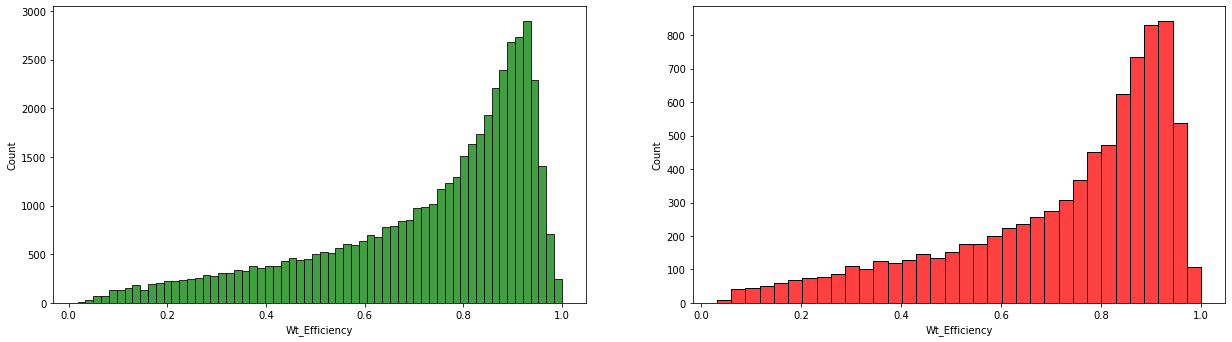

In [ ]:
# plt.figure(figsize=(21,12))
# plt.subplot(2,3,1)
# sns.histplot(train_set['Wt_Efficiency'], color = "green")
# plt.subplot(2,3,2)
# sns.histplot(train_set['eSpCas 9_Efficiency'], color = "green")
# plt.subplot(2,3,3)
# sns.histplot(train_set['SpCas9-HF1_Efficiency'], color = "green")

# plt.subplot(2,3,4)
# sns.histplot(test_set['Wt_Efficiency'], color = "red")
# plt.subplot(2,3,5)
# sns.histplot(test_set['eSpCas 9_Efficiency'], color = "red")
# plt.subplot(2,3,6)
# sns.histplot(test_set['SpCas9-HF1_Efficiency'], color = "red")

plt.figure(figsize=(21,12))
plt.subplot(2,2,1)
sns.histplot(train_set[cas_name], color = "green")
plt.subplot(2,2,2)
sns.histplot(test_set[cas_name], color = "red")

# Load CSV from Drive

In [ ]:
# import pandas as pd

# cas_name = 'Wt_Efficiency'
# #cas_name = 'eSpCas 9_Efficiency'
# #cas_name = 'SpCas9-HF1_Efficiency'

# train_df = pd.read_csv("dataset/train_" + cas_name + ".csv")
# test_df = pd.read_csv("dataset/test_" + cas_name + ".csv")

# Training CNN

In [ ]:
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten

from keras.layers import GRU, Bidirectional

from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.utils import np_utils
from scipy import stats

def get_model_name(k):
    return 'cnn_model_'+str(k)+'.h5'

def ohe_manual(seq):
    map = np.zeros((21,4), dtype=np.int8)
    dct = {'A': np.array([1,0,0,0]),'T': np.array([0,1,0,0]),'G': np.array([0,0,1,0]),'C': np.array([0,0,0,1])}
    lst = list(seq)
    for i in range(len(lst)):
        map[i] = dct[lst[i]]
    return map
    
def ohe_all_seq(seq_set):
    seq_set_enc = []
    for i in tqdm(range(len(seq_set))):
        seq_set_enc.append(ohe_manual(seq_set[i]))
    seq_set_enc = np.array(seq_set_enc)
    return seq_set_enc

def create_new_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(21,4)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model


test_model = create_new_model()
print(test_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19, 64)            832       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 64)            12352     
_________________________________________________________________
dropout (Dropout)            (None, 17, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [ ]:
#cas_name = 'Wt_Efficiency'
#cas_name = 'eSpCas 9_Efficiency'
cas_name = 'SpCas9-HF1_Efficiency'

model_name = 'cnn'

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf

target_col = cas_name

train_data = pd.read_csv("dataset/train_" + cas_name + ".csv")
X = ohe_all_seq(train_data['21mer']) # X numpy array of shape (sequence count, 21, 4); don't use iloc

Y = train_data[[target_col]] # Y dataframe with single column; use iloc

100%|██████████| 48354/48354 [00:00<00:00, 49381.09it/s]


In [ ]:
kf = KFold(n_splits = 5, shuffle=True, random_state=0)


VALIDATION_CORR = []
VALIDATION_LOSS = []

save_dir = 'saved_models/'
try:
    os.mkdir(save_dir)
except:
    pass

model_path = save_dir + cas_name + "_" + model_name + "/"
try:
    os.mkdir(model_path)
except:
    pass


fold_var = 1

for train_index, val_index in kf.split(X,Y):
    X_train = X[train_index]
    Y_train = Y.iloc[train_index]
    X_val = X[val_index]
    Y_val = Y.iloc[val_index]
    
    # CREATE NEW MODEL
    model = create_new_model()
    # COMPILE NEW MODEL
    
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])

    
    # CREATE CALLBACKS
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path+get_model_name(fold_var), 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
    callbacks_list = [checkpoint, es]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(X_train,Y_train,
                epochs=100,
                batch_size=64,
                callbacks=callbacks_list,
                validation_data=(X_val, Y_val))
    #PLOT HISTORY
    #       :
    #       :
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(model_path + "cnn_model_"+str(fold_var)+".h5")
    
    results = model.evaluate(X_val, Y_val)
    results = dict(zip(model.metrics_names,results))
    
    Y_pred = model.predict(X_val)
    Y_val = np.array(Y_val).reshape(len(Y_val),1)
    spearmancorr = (stats.spearmanr(Y_pred,Y_val))

    with open(model_path + "cnn_spcorr_val_"+str(fold_var)+".txt", "w") as f:
        f.write(str(spearmancorr))

    VALIDATION_CORR.append(spearmancorr)
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

print(VALIDATION_LOSS)
print(np.mean(VALIDATION_LOSS))
print(VALIDATION_CORR)
print(np.mean(VALIDATION_CORR))

Epoch 1/100
605/605 [==============================] - 5s 4ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0232 - val_mean_squared_error: 0.0232

Epoch 00001: val_loss improved from inf to 0.02318, saving model to saved_models/SpCas9-HF1_Efficiency_cnn/cnn_model_1.h5
Epoch 2/100
605/605 [==============================] - 2s 3ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0211 - val_mean_squared_error: 0.0211

Epoch 00002: val_loss improved from 0.02318 to 0.02106, saving model to saved_models/SpCas9-HF1_Efficiency_cnn/cnn_model_1.h5
Epoch 3/100
605/605 [==============================] - 2s 3ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0192 - val_mean_squared_error: 0.0192

Epoch 00003: val_loss improved from 0.02106 to 0.01915, saving model to saved_models/SpCas9-HF1_Efficiency_cnn/cnn_model_1.h5
Epoch 4/100
605/605 [==============================] - 2s 3ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 0.0194 - va

In [ ]:
corr = [VC[0] for VC in VALIDATION_CORR]
print(corr)
print(np.mean(corr))

[0.799641272088067, 0.7946301711993933, 0.7892242897256424, 0.7917748148333452, 0.7936491866418071]
0.793783946897651


saved_models/SpCas9-HF1_Efficiency_cnn/


100%|██████████| 8534/8534 [00:00<00:00, 52784.99it/s]


SpearmanrResult(correlation=0.7853817264553935, pvalue=0.0)


(0.0, 1.0)

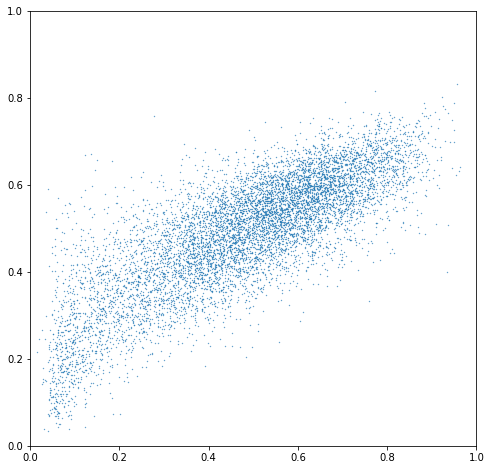

In [ ]:
import matplotlib.pyplot as plt

model = create_new_model()
# COMPILE NEW MODEL

model.compile(loss='mean_squared_error',
        optimizer='adam',
        metrics=['mean_squared_error'])

fold_var = 1

print(model_path)
model.load_weights(model_path + "cnn_model_"+str(fold_var)+".h5")

test_data = pd.read_csv('dataset/test_' + cas_name + '.csv')
X_ = ohe_all_seq(test_data['21mer']) # X numpy array of shape (sequence count, 21, 4); don't use iloc

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.1)
plt.ylim((0,1))
plt.xlim((0,1))

# Training C-RNNCrispr sequence branch only

In [ ]:
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten

from keras.layers import GRU, Bidirectional

from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.utils import np_utils
from scipy import stats

def get_model_name(k):
    return 'crnn_model_'+str(k)+'.h5'

def ohe_manual(seq):
    map = np.zeros((21,4), dtype=np.int8)
    dct = {'A': np.array([1,0,0,0]),'T': np.array([0,1,0,0]),'G': np.array([0,0,1,0]),'C': np.array([0,0,0,1])}
    lst = list(seq)
    for i in range(len(lst)):
        map[i] = dct[lst[i]]
    return map
    
def ohe_all_seq(seq_set):
    seq_set_enc = []
    for i in tqdm(range(len(seq_set))):
        seq_set_enc.append(ohe_manual(seq_set[i]))
    seq_set_enc = np.array(seq_set_enc)
    return seq_set_enc

def create_new_model():
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(21,4)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# DOUBLE CONV LAYER
# def create_new_model():
#     model = Sequential()
#     model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(21,4)))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Bidirectional(GRU(256, return_sequences=True)))
#     model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Bidirectional(GRU(128, return_sequences=True)))
    
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(40, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(Dense(1, activation='sigmoid'))
#     return model

test_model = create_new_model()
print(test_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19, 256)           3328      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 256)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 9, 512)            789504    
_________________________________________________________________
dense (Dense)                (None, 9, 256)            131328    
_________________________________________________________________
dense_1 (Dense)              (None, 9, 128)            32896     
_________________________________________________________________
dense_2 (Dense)              (None, 9, 64)             8256      
_________________________________________________________________
dense_3 (Dense)              (None, 9, 40)             2

In [ ]:
#cas_name = 'Wt_Efficiency'
#cas_name = 'eSpCas 9_Efficiency'
cas_name = 'SpCas9-HF1_Efficiency'

model_name = 'crnn'

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf

target_col = cas_name

train_data = pd.read_csv('dataset/train_' + cas_name + '.csv')
X = ohe_all_seq(train_data['21mer']) # X numpy array of shape (sequence count, 21, 4); don't use iloc

Y = train_data[[target_col]] # Y dataframe with single column; use iloc

100%|██████████| 48354/48354 [00:00<00:00, 51885.73it/s]


In [ ]:
kf = KFold(n_splits = 5, shuffle=True, random_state=0)


VALIDATION_CORR = []
VALIDATION_LOSS = []

save_dir = 'saved_models/'
try:
    os.mkdir(save_dir)
except:
    pass

model_path = save_dir + cas_name + "_" + model_name + "/"
try:
    os.mkdir(model_path)
except:
    pass

fold_var = 1

for train_index, val_index in kf.split(X,Y):
    X_train = X[train_index]
    Y_train = Y.iloc[train_index]
    X_val = X[val_index]
    Y_val = Y.iloc[val_index]
    
    # CREATE NEW MODEL
    model = create_new_model()
    # COMPILE NEW MODEL
    
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])

    
    # CREATE CALLBACKS
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path+get_model_name(fold_var), 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
    callbacks_list = [checkpoint, es]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(X_train,Y_train,
                epochs=100,
                batch_size=64,
                callbacks=callbacks_list,
                validation_data=(X_val, Y_val))
    #PLOT HISTORY
    #       :
    #       :
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(model_path + "crnn_model_"+str(fold_var)+".h5")
    
    results = model.evaluate(X_val, Y_val)
    results = dict(zip(model.metrics_names,results))
    
    Y_pred = model.predict(X_val)
    Y_val = np.array(Y_val).reshape(len(Y_val),1)
    spearmancorr = (stats.spearmanr(Y_pred,Y_val))

    with open(model_path + "crnn_spcorr_val_"+str(fold_var)+".txt", "w") as f:
        f.write(str(spearmancorr))

    VALIDATION_CORR.append(spearmancorr)
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

print(VALIDATION_LOSS)
print(np.mean(VALIDATION_LOSS))
print(VALIDATION_CORR)
print(np.mean(VALIDATION_CORR))

Epoch 1/100
605/605 [==============================] - 11s 10ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0190 - val_mean_squared_error: 0.0190

Epoch 00001: val_loss improved from inf to 0.01896, saving model to saved_models/SpCas9-HF1_Efficiency_crnn/crnn_model_1.h5
Epoch 2/100
605/605 [==============================] - 6s 10ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0163 - val_mean_squared_error: 0.0163

Epoch 00002: val_loss improved from 0.01896 to 0.01626, saving model to saved_models/SpCas9-HF1_Efficiency_crnn/crnn_model_1.h5
Epoch 3/100
605/605 [==============================] - 6s 10ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0145 - val_mean_squared_error: 0.0145

Epoch 00003: val_loss improved from 0.01626 to 0.01449, saving model to saved_models/SpCas9-HF1_Efficiency_crnn/crnn_model_1.h5
Epoch 4/100
605/605 [==============================] - 5s 8ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0

In [ ]:
corr = [VC[0] for VC in VALIDATION_CORR]
print(corr)
print(np.mean(corr))

[0.822090444904734, 0.8172551776874987, 0.815263564600977, 0.8158940306092525, 0.8168754255397609]
0.8174757286684446


100%|██████████| 8534/8534 [00:00<00:00, 47598.47it/s]


SpearmanrResult(correlation=0.8131136970464499, pvalue=0.0)


(0.0, 1.0)

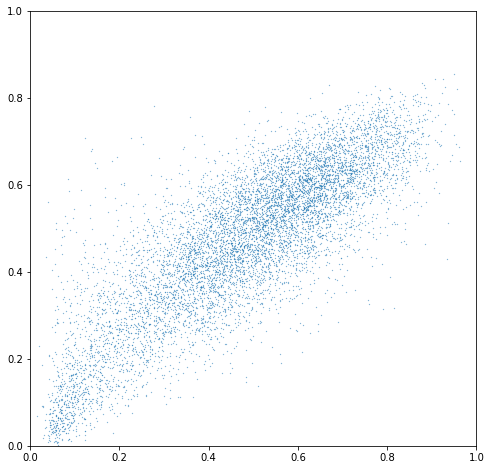

In [ ]:
import matplotlib.pyplot as plt

model = create_new_model()
# COMPILE NEW MODEL

model.compile(loss='mean_squared_error',
        optimizer='adam',
        metrics=['mean_squared_error'])

fold_var = 1

model.load_weights(model_path + "crnn_model_"+str(fold_var)+".h5")
    
test_data = pd.read_csv('dataset/test_' + cas_name + '.csv')
X_ = ohe_all_seq(test_data['21mer']) # X numpy array of shape (sequence count, 21, 4); don't use iloc

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.05)
plt.ylim((0,1))
plt.xlim((0,1))

# BiLSTM with Attention

In [ ]:
#cas_name = 'Wt_Efficiency'
#cas_name = 'eSpCas 9_Efficiency'
cas_name = 'SpCas9-HF1_Efficiency'

model_name = 'att_bilstm'

In [ ]:
# LOAD TRAIN DATA

import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf

target_col = cas_name

train_data = pd.read_csv('dataset/train_' + cas_name + '.csv')
X = train_data['21mer']

Y = train_data[[target_col]] # Y dataframe with single column; use iloc

In [ ]:
# CONVERT TO KMER
base_dict = {'A':0,'T':1,'G':2,'C':3}

from tqdm import tqdm

def Gen_Words(sequence,kmer_len,s):
    kmer_list=[]
    for j in range(0,(len(sequence)-kmer_len)+1,s):
        #kmer_list.append(sequence[j:j+kmer_len])
        kmer = sequence[j:j+kmer_len]
        kmer_len = len(kmer)
        multiplier = 1
        val = 0
        for k in range(1,kmer_len+1):
            val += (base_dict[kmer[kmer_len-k]]*multiplier)
            multiplier *= 4
        kmer_list.append(val)
    return kmer_list

def word_generation_all_sequences(seq_df,kmer_len,stride):
    seq_set_enc = []
    for i in tqdm(range(len(seq_df))):
        seq_set_enc.append(Gen_Words(seq_df.iloc[i],kmer_len,stride))
    #seq_set_enc = np.array(seq_set_enc)
    return seq_set_enc

def splitkmer(sentences):
    kmer_len = 3
    stride = 2
    sequence_words = word_generation_all_sequences(sentences,kmer_len,stride)
    #print(sequence_words)
    #print(len(sequence_words))
    return sequence_words

X = np.array((splitkmer(X)))
print(X.shape)
print(X[0])

# ['AAC', 'CCT', 'TCA', 'AAA', 'ATA', 'AGC', 'CGT', 'TGC', 'CCA', 'AGG']

100%|██████████| 48354/48354 [00:00<00:00, 53998.75it/s]

(48354, 10)
[ 8  6 40  4  3 51 50 38 34 45]


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer


def get_model_name(k):
    return 'att_bilstm_model_'+str(k)+'.h5'


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2
            hidden = LSTM(64, return_sequences=True)(words)
            sentence = Attention()(hidden)
            # next add a Dense layer (for classification/regression) or whatever...
        """
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(name='{}_W'.format(self.name),
                                 shape=(input_shape[-1],),
                                 initializer=self.init,
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(name='{}_b'.format(self.name),
                                     shape=(input_shape[1],),
                                     initializer='zero',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        e = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))  # e = K.dot(x, self.W)
        if self.bias:
            e += self.b
        e = K.tanh(e)

        a = K.exp(e)
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)

        c = K.sum(a * x, axis=1)
        return c

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class TextAttBiRNN(Model):
    def __init__(self,
                 maxlen,
                 max_features,
                 embedding_dims,
                 class_num=1,
                 last_activation='linear'):
        super(TextAttBiRNN, self).__init__()
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation
        self.embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)
        self.bi_rnn = Bidirectional(LSTM(128, return_sequences=True))  # LSTM or GRU
        self.attention = Attention(self.maxlen)
        self.internal = Dense(64, activation='relu')
        self.dropout = Dropout(0.25)
        self.classifier = Dense(self.class_num, activation=self.last_activation)

    def call(self, inputs):
        if len(inputs.get_shape()) != 2:
            raise ValueError('The rank of inputs of TextAttBiRNN must be 2, but now is %d' % len(inputs.get_shape()))
        if inputs.get_shape()[1] != self.maxlen:
            raise ValueError('The maxlen of inputs of TextAttBiRNN must be %d, but now is %d' % (self.maxlen, inputs.get_shape()[1]))
        embedding = self.embedding(inputs)
        x = self.bi_rnn(embedding)
        x = self.attention(x)
        x = self.internal(x)
        x = self.dropout(x)
        output = self.classifier(x)
        return output

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from scipy import stats

max_features = 64
maxlen = 10
batch_size = 64

embedding_dims = 20


kf = KFold(n_splits = 5, shuffle=True, random_state=0)


VALIDATION_CORR = []
VALIDATION_LOSS = []

save_dir = 'saved_models/'
try:
    os.mkdir(save_dir)
except:
    pass

model_path = save_dir + cas_name + "_" + model_name + "/"
try:
    os.mkdir(model_path)
except:
    pass



fold_var = 1

for train_index, val_index in kf.split(X,Y):
    X_train = X[train_index]
    Y_train = Y.iloc[train_index]
    X_val = X[val_index]
    Y_val = Y.iloc[val_index]
    

    model = TextAttBiRNN(maxlen, max_features, embedding_dims)
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
    

    # CREATE CALLBACKS
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path+get_model_name(fold_var), 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
    callbacks_list = [checkpoint, es]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(X_train,Y_train,
                epochs=100,
                batch_size=batch_size,
                callbacks=callbacks_list,
                validation_data=(X_val, Y_val))
    #PLOT HISTORY
    #       :
    #       :
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(model_path + "att_bilstm_model_"+str(fold_var)+".h5")
    
    results = model.evaluate(X_val, Y_val)
    results = dict(zip(model.metrics_names,results))
    
    Y_pred = model.predict(X_val)
    Y_val = np.array(Y_val).reshape(len(Y_val),1)
    spearmancorr = (stats.spearmanr(Y_pred,Y_val))

    with open(model_path + "att_bilstm_spcorr_val_"+str(fold_var)+".txt", "w") as f:
        f.write(str(spearmancorr))

    VALIDATION_CORR.append(spearmancorr)
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

print(VALIDATION_LOSS)
print(np.mean(VALIDATION_LOSS))
print(VALIDATION_CORR)
print(np.mean(VALIDATION_CORR))

Epoch 1/100
605/605 [==============================] - 10s 9ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 0.0288 - val_mean_squared_error: 0.0288

Epoch 00001: val_loss improved from inf to 0.02876, saving model to saved_models/SpCas9-HF1_Efficiency_att_bilstm/att_bilstm_model_1.h5
Epoch 2/100
605/605 [==============================] - 4s 7ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0254 - val_mean_squared_error: 0.0254

Epoch 00002: val_loss improved from 0.02876 to 0.02544, saving model to saved_models/SpCas9-HF1_Efficiency_att_bilstm/att_bilstm_model_1.h5
Epoch 3/100
605/605 [==============================] - 5s 8ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0244 - val_mean_squared_error: 0.0244

Epoch 00003: val_loss improved from 0.02544 to 0.02442, saving model to saved_models/SpCas9-HF1_Efficiency_att_bilstm/att_bilstm_model_1.h5
Epoch 4/100
605/605 [==============================] - 4s 7ms/step - loss: 0.0252 - mean_sq

In [ ]:
corr = [VC[0] for VC in VALIDATION_CORR]
print(corr)
print(np.mean(corr))

[0.8376043315357293, 0.83879538649873, 0.8329679039068653, 0.8389478455635225, 0.8327643273258041]
0.8362159589661303


1/1 [==============================] - 2s 2s/step - loss: 0.1495 - mean_squared_error: 0.1495


100%|██████████| 8534/8534 [00:00<00:00, 60480.22it/s]


SpearmanrResult(correlation=0.8359173925876584, pvalue=0.0)
Model: "text_att_bi_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1280      
_________________________________________________________________
bidirectional (Bidirectional multiple                  152576    
_________________________________________________________________
attention (Attention)        multiple                  266       
_________________________________________________________________
dense (Dense)                multiple                  16448     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  65        
Total params: 170,635
Trainable params: 170,635
Non-train

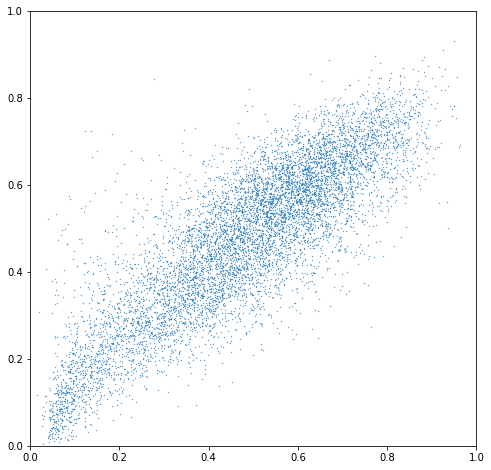

In [ ]:
import matplotlib.pyplot as plt

model = TextAttBiRNN(maxlen, max_features, embedding_dims)
# COMPILE NEW MODEL

model.compile(loss='mean_squared_error',
        optimizer='adam',
        metrics=['mean_squared_error'])

model.fit(X[0].reshape(1,10),Y.iloc[0],epochs=1,batch_size=1)

fold_var = 4

model.load_weights(model_path + "att_bilstm_model_"+str(fold_var)+".h5")
    
test_data = pd.read_csv('dataset/test_' + cas_name + '.csv')
X_ = test_data['21mer'] # X numpy array of shape (sequence count, 21, 4); don't use iloc
X_ = np.array((splitkmer(X_)))

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.1)
plt.ylim((0,1))
plt.xlim((0,1))

model.summary()

# HAN

In [ ]:
#cas_name = 'Wt_Efficiency'
#cas_name = 'eSpCas 9_Efficiency'
cas_name = 'SpCas9-HF1_Efficiency'

model_name = 'han'

In [ ]:
# LOAD TRAIN DATA

import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf

target_col = cas_name

train_data = pd.read_csv('dataset/train_' + cas_name + '.csv')
X = train_data['21mer']

Y = train_data[[target_col]] # Y dataframe with single column; use iloc

In [ ]:
# CONVERT TO KMER
base_dict = {'A':0,'T':1,'G':2,'C':3}

from tqdm import tqdm

def Gen_Words(sequence,kmer_len,s):
    kmer_list=[]
    for j in range(0,(len(sequence)-kmer_len)+1,s):
        tmp = []
        for x in sequence[j:j+kmer_len]:
            tmp.append(base_dict[x])
        kmer_list.append(tmp)
        # kmer = sequence[j:j+kmer_len]
        # kmer_len = len(kmer)
        # multiplier = 1
        # val = 0
        # for k in range(1,kmer_len+1):
        #     val += (base_dict[kmer[kmer_len-k]]*multiplier)
        #     multiplier *= 4
        # kmer_list.append(val)
    return kmer_list

def word_generation_all_sequences(seq_df,kmer_len,stride):
    seq_set_enc = []
    for i in tqdm(range(len(seq_df))):
        seq_set_enc.append(Gen_Words(seq_df.iloc[i],kmer_len,stride))
    #seq_set_enc = np.array(seq_set_enc)
    return seq_set_enc

def splitkmer(sentences):
    kmer_len = 3
    stride = 2
    sequence_words = word_generation_all_sequences(sentences,kmer_len,stride)
    #print(sequence_words)
    #print(len(sequence_words))
    return sequence_words

X = np.array((splitkmer(X)))
print(X.shape)
print(X[0])

# ['AAC', 'CCT', 'TCA', 'AAA', 'ATA', 'AGC', 'CGT', 'TGC', 'CCA', 'AGG']

100%|██████████| 48354/48354 [00:01<00:00, 41126.25it/s]

(48354, 10, 3)
[[0 2 0]
 [0 1 2]
 [2 2 0]
 [0 1 0]
 [0 0 3]
 [3 0 3]
 [3 0 2]
 [2 1 2]
 [2 0 2]
 [2 3 1]]


In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU, Dropout, TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer

def get_model_name(k):
    return 'han_model_'+str(k)+'.h5'


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2
            hidden = LSTM(64, return_sequences=True)(words)
            sentence = Attention()(hidden)
            # next add a Dense layer (for classification/regression) or whatever...
        """
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(name='{}_W'.format(self.name),
                                 shape=(input_shape[-1],),
                                 initializer=self.init,
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(name='{}_b'.format(self.name),
                                     shape=(input_shape[1],),
                                     initializer='zero',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        e = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))  # e = K.dot(x, self.W)
        if self.bias:
            e += self.b
        e = K.tanh(e)

        a = K.exp(e)
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)

        c = K.sum(a * x, axis=1)
        return c

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim



class HAN(Model):
    def __init__(self,
                 maxlen_sentence,
                 maxlen_word,
                 max_features,
                 embedding_dims,
                 class_num=1,
                 last_activation='sigmoid'):
        super(HAN, self).__init__()
        self.maxlen_sentence = maxlen_sentence
        self.maxlen_word = maxlen_word
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation
        # Word part
        input_word = Input(shape=(self.maxlen_word,))
        x_word = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen_word)(input_word)
        x_word = Bidirectional(LSTM(128, return_sequences=True))(x_word)  # LSTM or GRU
        x_word = Attention(self.maxlen_word)(x_word)
        model_word = Model(input_word, x_word)
        # Sentence part
        self.word_encoder_att = TimeDistributed(model_word)
        self.sentence_encoder = Bidirectional(LSTM(128, return_sequences=True))  # LSTM or GRU
        self.sentence_att = Attention(self.maxlen_sentence)
        # Output part
        self.classifier = Dense(self.class_num, activation=self.last_activation)

    def call(self, inputs):
        if len(inputs.get_shape()) != 3:
            raise ValueError('The rank of inputs of HAN must be 3, but now is %d' % len(inputs.get_shape()))
        if inputs.get_shape()[1] != self.maxlen_sentence:
            raise ValueError('The maxlen_sentence of inputs of HAN must be %d, but now is %d' % (self.maxlen_sentence, inputs.get_shape()[1]))
        if inputs.get_shape()[2] != self.maxlen_word:
            raise ValueError('The maxlen_word of inputs of HAN must be %d, but now is %d' % (self.maxlen_word, inputs.get_shape()[2]))
        x_sentence = self.word_encoder_att(inputs)
        x_sentence = self.sentence_encoder(x_sentence)
        x_sentence = self.sentence_att(x_sentence)
        output = self.classifier(x_sentence)
        return output


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from scipy import stats
import keras

batch_size = 64
epoch_cnt = 100

maxlen_sentence = 10
maxlen_word=3
max_features=4

embedding_dims=20

kf = KFold(n_splits = 5, shuffle=True, random_state=0)


VALIDATION_CORR = []
VALIDATION_LOSS = []

save_dir = 'saved_models/'
try:
    os.mkdir(save_dir)
except:
    pass

model_path = save_dir + cas_name + "_" + model_name + "/"
try:
    os.mkdir(model_path)
except:
    pass


fold_var = 1

for train_index, val_index in kf.split(X,Y):
    X_train = X[train_index]
    Y_train = Y.iloc[train_index]
    X_val = X[val_index]
    Y_val = Y.iloc[val_index]
    

    
    model = HAN(maxlen_sentence, maxlen_word, max_features, embedding_dims)

    #optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epoch_cnt, amsgrad=False)
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
    

    # CREATE CALLBACKS
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path+get_model_name(fold_var), 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
    callbacks_list = [checkpoint, es]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    print(X_train.shape)
    history = model.fit(X_train,Y_train,
                epochs=epoch_cnt,
                batch_size=batch_size,
                callbacks=callbacks_list,
                validation_data=(X_val, Y_val))
    #PLOT HISTORY
    #       :
    #       :
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(model_path + "han_model_"+str(fold_var)+".h5")
    
    results = model.evaluate(X_val, Y_val)
    results = dict(zip(model.metrics_names,results))
    
    Y_pred = model.predict(X_val)
    Y_val = np.array(Y_val).reshape(len(Y_val),1)
    spearmancorr = (stats.spearmanr(Y_pred,Y_val))

    with open(model_path + "han_spcorr_val_"+str(fold_var)+".txt", "w") as f:
        f.write(str(spearmancorr))

    VALIDATION_CORR.append(spearmancorr)
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

print(VALIDATION_LOSS)
print(np.mean(VALIDATION_LOSS))
print(VALIDATION_CORR)
print(np.mean(VALIDATION_CORR))

(38683, 10, 3)
Epoch 1/100
605/605 [==============================] - 16s 14ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0331 - val_mean_squared_error: 0.0331

Epoch 00001: val_loss improved from inf to 0.03313, saving model to saved_models/SpCas9-HF1_Efficiency_han/han_model_1.h5
Epoch 2/100
605/605 [==============================] - 7s 11ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0269 - val_mean_squared_error: 0.0269

Epoch 00002: val_loss improved from 0.03313 to 0.02692, saving model to saved_models/SpCas9-HF1_Efficiency_han/han_model_1.h5
Epoch 3/100
605/605 [==============================] - 7s 11ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0221 - val_mean_squared_error: 0.0221

Epoch 00003: val_loss improved from 0.02692 to 0.02210, saving model to saved_models/SpCas9-HF1_Efficiency_han/han_model_1.h5
Epoch 4/100
605/605 [==============================] - 7s 11ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - v

In [ ]:
corr = [VC[0] for VC in VALIDATION_CORR]
print(corr)
print(np.mean(corr))

[0.8184940330196837, 0.8222144521200229, 0.8164245888015956, 0.8259784417140462, 0.8256417887644236]
0.8217506608839544


1/1 [==============================] - 5s 5s/step - loss: 0.0130 - mean_squared_error: 0.0130


100%|██████████| 8534/8534 [00:00<00:00, 35558.72it/s]


SpearmanrResult(correlation=0.8303764045723439, pvalue=0.0)
Model: "han_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist multiple                  152915    
_________________________________________________________________
bidirectional_5 (Bidirection multiple                  394240    
_________________________________________________________________
attention_5 (Attention)      multiple                  266       
_________________________________________________________________
dense_2 (Dense)              multiple                  257       
Total params: 547,678
Trainable params: 547,678
Non-trainable params: 0
_________________________________________________________________


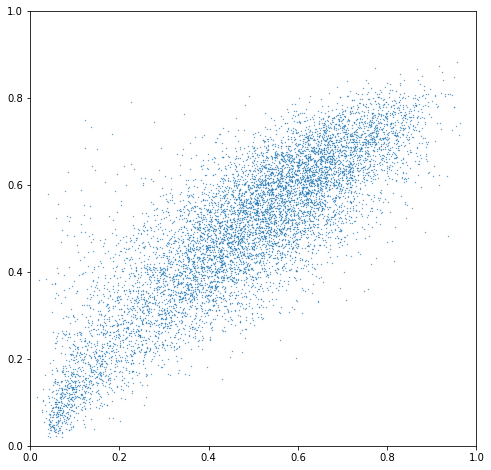

In [ ]:
import matplotlib.pyplot as plt

model = HAN(maxlen_sentence, maxlen_word, max_features, embedding_dims)
# COMPILE NEW MODEL

model.compile(loss='mean_squared_error',
        optimizer='adam',
        metrics=['mean_squared_error'])

model.fit(X[0].reshape(1,10,3),Y.iloc[0],epochs=1,batch_size=1)

fold_var = 5

model.load_weights(model_path + "han_model_"+str(fold_var)+".h5")
    
test_data = pd.read_csv('dataset/test_' + cas_name + '.csv')
X_ = test_data['21mer'] # X numpy array of shape (sequence count, 21, 4); don't use iloc
X_ = np.array((splitkmer(X_)))

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.1)
plt.ylim((0,1))
plt.xlim((0,1))

model.summary()

# UNNECESSARY

In [ ]:
test_data = pd.read_csv('test.csv')
X_ = ohe_all_seq(test_data['21mer']) # X numpy array of shape (sequence count, 21, 4); don't use iloc

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

100%|██████████| 8091/8091 [00:00<00:00, 34493.14it/s]


SpearmanrResult(correlation=0.8134764616986512, pvalue=0.0)


(0.0, 1.0)

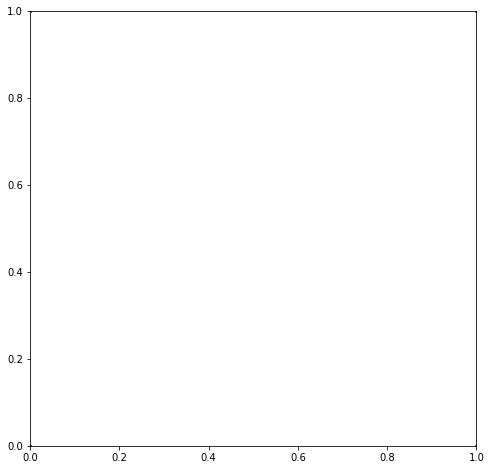

In [ ]:
print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.05)
plt.ylim((0,1))
plt.xlim((0,1))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from keras.models import model_from_json
from livelossplot import PlotLossesKeras

ModuleNotFoundError: ignored

In [ ]:
### Taking 70% of the original dataset into training and 10% to validation for now
### Doing it for SpCas9HF1 only for now
train_val = train_set.sample(frac=1).reset_index(drop=True)
brk_pt = int(df1.shape[0]*0.7)
train_set_ = train_val.iloc[:brk_pt].copy().reset_index(drop=True)
val_set_ = train_val.iloc[brk_pt:].copy().reset_index(drop=True)

train_set_X = train_set_['21mer']
val_set_X = val_set_['21mer']
train_set_Y = train_set_['SpCas9-HF1_Efficiency']
val_set_Y = val_set_['SpCas9-HF1_Efficiency']

print(train_set_X.shape)
print(val_set_X.shape)
print(train_set_Y.shape)
print(val_set_Y.shape)

(37755,)
(5394,)
(37755,)
(5394,)


In [ ]:
def ohe_manual(seq):
    map = np.zeros((21,4), dtype=np.int8)
    dct = {'A': np.array([1,0,0,0]),'T': np.array([0,1,0,0]),'G': np.array([0,0,1,0]),'C': np.array([0,0,0,1])}
    lst = list(seq)
    for i in range(len(lst)):
        map[i] = dct[lst[i]]
    return map
    
def ohe_all_seq(seq_set):
    seq_set_enc = []
    for i in tqdm(range(len(seq_set))):
        seq_set_enc.append(ohe_manual(seq_set[i]))
    seq_set_enc = np.array(seq_set_enc)
    return seq_set_enc

In [ ]:
train_set_X_ohe = ohe_all_seq(train_set_X)
val_set_X_ohe = ohe_all_seq(val_set_X)
print()
print(train_set_X_ohe.shape)
print(val_set_X_ohe.shape)

100%|██████████| 5394/5394 [00:00<00:00, 48484.08it/s]


(37755, 21, 4)
(5394, 21, 4)


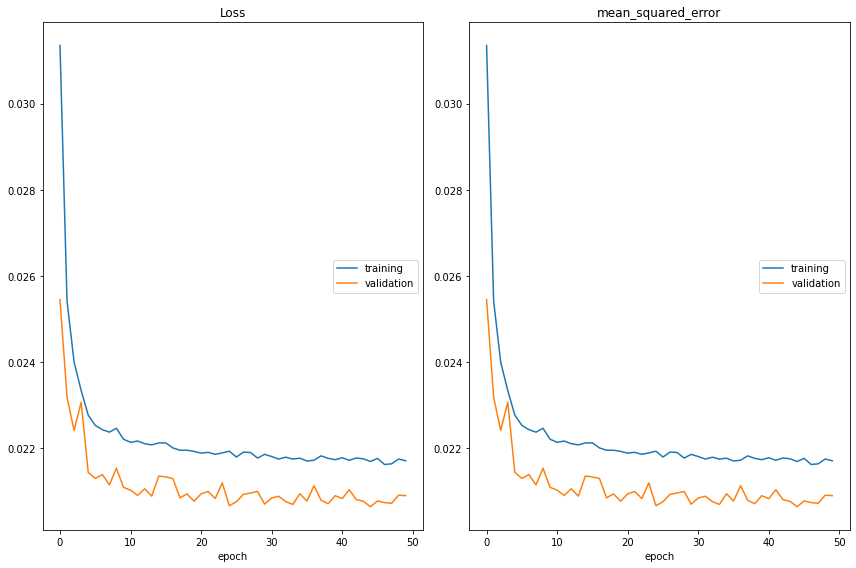

Loss
	training         	 (min:    0.022, max:    0.031, cur:    0.022)
	validation       	 (min:    0.021, max:    0.025, cur:    0.021)
mean_squared_error
	training         	 (min:    0.022, max:    0.031, cur:    0.022)
	validation       	 (min:    0.021, max:    0.025, cur:    0.021)
189/189 [==============================] - 11s 57ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Saved model to disk


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
# load data
(X_train, y_train), (X_test, y_test) = (train_set_X_ohe, train_set_Y), (val_set_X_ohe, val_set_Y)
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 21, 4, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 21, 4, 1)).astype('float32')

def model():
	# create model
	# model = Sequential()
	# # model.add(Conv2D(32, (4, 4), input_shape=(21, 4, 1), activation='relu', padding='same'))
	# model.add(Conv2D(32, (3, 3), input_shape=(21, 4, 1), activation='relu', padding='valid'))
	# model.add(MaxPooling2D())
	# # model.add(Conv2D(16, (2, 2), activation='relu', padding='same'))
	# model.add(Conv2D(16, (1, 1), activation='relu'))
	# # model.add(MaxPooling2D())
	# model.add(Dropout(0.2))
	# model.add(Flatten())
	# model.add(Dense(128, activation='relu'))
	# model.add(Dense(50, activation='relu'))
	# model.add(Dense(1, activation='sigmoid'))
	# # Compile model
	model = Sequential()
	model.add(Conv2D(256, (2, 2), input_shape=(21, 4, 1), activation='relu', padding='valid'))
	model.add(MaxPooling2D())
	model.add(Dense(256, activation='relu'))
	model.add(Dense(128, activation='relu'))
	model.add(Dense(64, activation='relu'))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
 
	model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
	return model
# build the model
model = model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, callbacks=[PlotLossesKeras()])

# serialize model to JSON
model_json = model.to_json()
with open("model_cnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn.h5")
print("Saved model to disk")

SpearmanrResult(correlation=0.7457305693567978, pvalue=0.0)


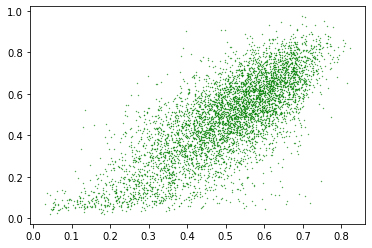

In [ ]:
y_pred = model.predict(X_test)
y_test = np.array(y_test).reshape(len(y_test),1)
print(stats.spearmanr(y_pred,y_test))
plt.scatter(y_pred, y_test,s=0.1, color="green")

In [ ]:
# load json and create model
json_file = open('model_cnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_cnn.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


y_pred = loaded_model.predict(X_test)
y_test = np.array(y_test).reshape(len(y_test),1)
print(stats.spearmanr(y_pred,y_test))
plt.scatter(y_pred, y_test,s=0.1, color="green")


Loaded model from disk


NameError: ignored